In [1]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
import uuid
from typing import Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph.message import MessagesState, add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
import time

load_dotenv()


True

## Jednoduchy chatbot

### 1. Definice stavu agenta

In [2]:
class State(MessagesState):
    # `add_messages` anotace automaticky prida zpravy do seznamu
    messages: Annotated[list, add_messages]


### 2. Definice vrcholů, hran a grafu

In [ ]:
model = init_chat_model("google_genai:gemini-2.0-flash")


def invoke_llm_node(state: State):
    # metode `invoke` se predava kompletni seznam zprav jako kontext
    ai_message = model.invoke(state["messages"])
    ai_message.pretty_print()

    return {"messages": [ai_message]}


def prompt_user_node(_: State):
    time.sleep(0.5)  # kvuli iffy renderingu

    user_message = HumanMessage(input("You: ").strip())
    user_message.pretty_print()

    return {"messages": [user_message]}


def should_continue_edge(state: State):
    """
    Na zaklade posledni uzivatelovi zpravy rozhoduje, zda ma agent skoncit.
    """
    last_message = state["messages"][-1].content

    if len(last_message) == 0 or last_message.lower() == "exit":
        print("Exiting conversation...")
        return False
    else:
        return True
    


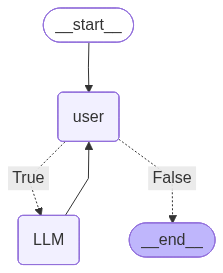

In [7]:
graph_builder = (
    StateGraph(State)
    .add_edge(START, "user")
    .add_node("user", prompt_user_node)
    .add_conditional_edges("user", should_continue_edge, {True: "LLM", False: END})
    .add_node("LLM", invoke_llm_node)
    .add_edge("LLM", "user")
)

# Kompilace grafu
graph = graph_builder.compile()

# Vizualizace
graph


### 3. Spusteni agenta

In [8]:
response = graph.invoke(
    {"messages": []}
)

================================ Human Message =================================

heelo?
================================== Ai Message ==================================

Hello! How can I help you today?
================================ Human Message =================================

not sure, how are you?
================================== Ai Message ==================================

As a large language model, I don't experience emotions or feelings like humans do. So, I don't have a "how are you" in the same way. However, I am functioning as intended and ready to assist you. What's on your mind? Is there anything I can help you with?
================================ Human Message =================================


Exiting conversation...


## Rozsireni o tooly

In [9]:
from langchain_core.tools import tool
from psycopg.rows import dict_row
from psycopg import Connection
from langgraph.prebuilt import InjectedState
from langchain_core.runnables import RunnableConfig

connection = Connection.connect(os.environ["DB_URI"], row_factory=dict_row)
cursor = connection.cursor()


class DBRepositoryToolKit:
    def get_tools(self):
        return [self.get_user_balance]

    @staticmethod
    @tool
    def get_user_balance(config: RunnableConfig) -> float:
        """
        Get up-to-date balance of the user's account.
        """
        
        user_id = config["configurable"]["user_id"]

        cursor.execute(
            """
            SELECT SUM(amount)
            FROM transactions WHERE user_id = %s
            GROUP BY user_id
            """,
            (user_id,),
        )
        result = cursor.fetchone()

        return result["sum"]


### Tool binding

In [10]:
database_toolkit = DBRepositoryToolKit()

model = model.bind_tools(database_toolkit.get_tools())

### Rozsireni grafu agenta

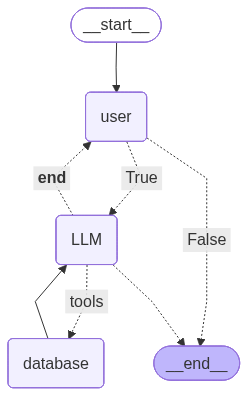

In [11]:
from langgraph.prebuilt import tools_condition, ToolNode

graph_builder = (
    StateGraph(State)
    .add_edge(START, "user")
    .add_node("user", prompt_user_node)
    .add_conditional_edges("user", should_continue_edge, {True: "LLM", False: END})
    .add_node("LLM", invoke_llm_node)
    .add_conditional_edges(
        "LLM",
        tools_condition,
        {"tools": "database", END: "user"},
    )
    .add_node("database", ToolNode(database_toolkit.get_tools()))
    .add_edge("database", "LLM")
)

# Kompilace grafu
graph = graph_builder.compile()

# Vizualizace
graph


### Spusteni agenta

In [ ]:
# Staticka konfigurace (napr. user session)
config = RunnableConfig(
    configurable={"user_id": "d8ebe7d8-e647-4d1a-b91e-3e7a3b6efd95"}
)

response = graph.invoke(
    {
        "messages": [
            SystemMessage(
                "You are a helpful customer support agent that helps customers with their account."
            ),
            AIMessage(
                "Hello, how can I help you today?"
            ),
        ]
    },
    config=config,
)
